In [1]:
import sys
sys.executable

'/Users/arshaq/Desktop/BO Cointegration/venv/bin/python'

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
prices_train = pd.read_excel("train_data.xlsx")
prices_test = pd.read_excel("test_data.xlsx")

In [4]:
print(prices_train.head())
print(prices_test.head())

        Date     BYDDF        TSLA
0 2023-01-03  8.265224  108.099998
1 2023-01-04  8.678808  113.639999
2 2023-01-05  8.630341  110.339996
3 2023-01-06  8.497865  113.059998
4 2023-01-09  8.423548  119.769997
        Date      BYDDF        TSLA
0 2025-02-03  11.572061  383.679993
1 2025-02-04  12.132531  392.209991
2 2025-02-05  12.050109  378.170013
3 2025-02-06  13.111706  374.320007
4 2025-02-07  13.879878  361.619995


In [5]:
prices_train = prices_train.set_index("Date")
prices_test = prices_test.set_index("Date")

prices_train = prices_train.astype("float64")
prices_test = prices_test.astype("float64")

log_prices_train = np.log(prices_train)
log_prices_test = np.log(prices_test)

BUILD THE SPREAD AND Z-SCORE

In [6]:
beta_norm = np.array([ 0.7199173, -0.2800827])

#Compute training spread
spread_train_val = log_prices_train @ beta_norm
spread_train = pd.Series(
    spread_train_val,
    index = log_prices_train.index,
    name = "spread_train"
)

#Sample Mean and Std
mu_spread = spread_train.mean()
sigma_spread = spread_train.std(ddof=1)

zscore_train = (spread_train - mu_spread)/sigma_spread
zscore_train.name = "zscore_train"

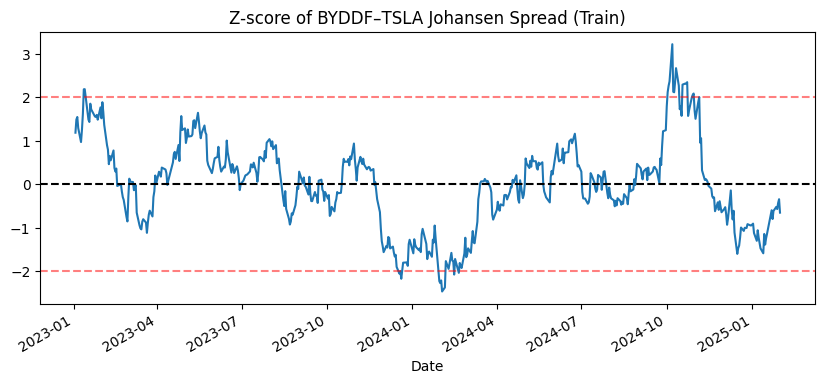

In [7]:
#Visualization
zscore_train.plot(figsize=(10, 4), title="Z-score of BYDDF–TSLA Johansen Spread (Train)")
plt.axhline(0, color="black", linestyle="--")
plt.axhline( 2, color="red", linestyle="--", alpha=0.5)
plt.axhline(-2, color="red", linestyle="--", alpha=0.5)
plt.show()

TRADING RULE TO GO LONG/SHORT

In [8]:
def generate_spread_positions(
        zscore: pd.Series,
        entry_z: float = 1.5,
        exit_z: float = 0.5
) -> pd.Series:
    """
    zscore: z_t of the spread
    Returns q_t in {-1, 0, +1}.
    """
    pos = pd.Series(index=zscore.index, dtype=float)
    current = 0.0
    for t,z in zscore.items():
        if current == 0.0:
            #Flat: look for entry
            if z > entry_z:
                current = -1.0
            elif z < -entry_z:
                current = +1.0
        else:
            #Already in position, look for exit
            if abs(z) < exit_z:
                current = 0.0
        pos.loc[t] = current
    
    pos.name = "spread_position"
    return pos

In [9]:
spread_pos_train = generate_spread_positions(
    zscore_train,
    entry_z=1.5,
    exit_z=0.5
)

In [10]:
spread_pos_train.value_counts()

spread_position
 0.0    354
 1.0     96
-1.0     72
Name: count, dtype: int64

ASSET WEIGHTS EACH DAY AND EXPOSURE 

In [11]:
def spread_to_asset_weights(
        spread_pos: pd.Series,
        beta_norm: np.ndarray,
        asset_names = ("BYDDF", "TSLA")
) -> pd.Series:
    """
    spread_pos: q_t in {-1, 0, +1}
    returns DataFrame of asset weights per day.
    """
    weights = pd.DataFrame(
        index=spread_pos.index,
        columns=list(asset_names),
        dtype=float
    )
    for t,q in spread_pos.items():
        weights.loc[t, :] = q * beta_norm
    return weights

In [12]:
weights_train = spread_to_asset_weights(
    spread_pos_train,
    beta_norm,
    asset_names=("BYDDF", "TSLA")
)

In [13]:
print(weights_train.head())
print(weights_train.abs().sum(axis=1).value_counts().head())

               BYDDF      TSLA
Date                          
2023-01-03  0.000000 -0.000000
2023-01-04  0.000000 -0.000000
2023-01-05 -0.719917  0.280083
2023-01-06 -0.719917  0.280083
2023-01-09 -0.719917  0.280083
0.0    354
1.0    168
Name: count, dtype: int64


TRAINING SET DAILY RETURNS AND SHARPE RATIO

In [14]:
#Simple return in the training window
returns_train = prices_train.pct_change().fillna(0.0)
returns_train.columns = ["BYDDF", "TSLA"]

#Lag weights -1
weights_train_shifted = weights_train.shift(1).fillna(0.0)

#Mean-reversion strat training daily returns
strat_ret_train = (weights_train_shifted * returns_train).sum(axis=1)
strat_ret_train.name = "strategy_returns_train"

#Sharpe Ratio
def annualised_sharpe(returns: pd.Series, periods_per_year: int = 252) -> float:
    mu = returns.mean()
    sigma = returns.std(ddof=1)
    if sigma == 0:
        return 0.0
    return (mu/sigma) * np.sqrt(periods_per_year)


In [15]:
shapre_train = annualised_sharpe(strat_ret_train)
print("Training set Sharpe Ratio for Johansen Spread: ", shapre_train)

Training set Sharpe Ratio for Johansen Spread:  1.100295554606335


In [16]:
print("Mean daily return:", strat_ret_train.mean())
print("Std daily return :", strat_ret_train.std(ddof=1))
print("Fraction of days in a position:",
      (weights_train.abs().sum(axis=1) > 0).mean())

Mean daily return: 0.000821926774041272
Std daily return : 0.01185834386541798
Fraction of days in a position: 0.3218390804597701


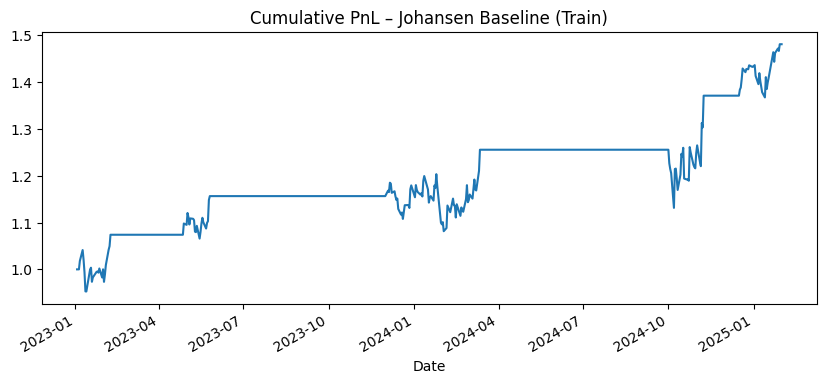

In [17]:
(1 + strat_ret_train).cumprod().plot(figsize=(10,4),
                                     title="Cumulative PnL – Johansen Baseline (Train)")
plt.show()

TEST SET PERFORMANCE AND SHARPE RATIO

In [18]:
spread_test_vals = log_prices_test @ beta_norm
spread_test = pd.Series(spread_test_vals, index=log_prices_test.index, name="spread_test")

zscore_test = (spread_test - mu_spread)/sigma_spread
zscore_test.name = "zscore_test"

In [19]:
#Positions and weights for Test Set

spread_pos_test = generate_spread_positions(
    zscore_test,
    entry_z=1.5,
    exit_z=0.5
)

weight_test = spread_to_asset_weights(
    spread_pos_test,
    beta_norm,
    asset_names=("BYDDF", "TSLA")
)

weight_test_shifted = weight_test.shift(1).fillna(0.0)

In [20]:
#Test set returns and Sharpe Ratio
returns_test = prices_test.pct_change().fillna(0.0)
returns_test.columns = ["BYDDF", "TSLA"]

strat_ret_test = (weight_test_shifted * returns_test).sum(axis=1)
strat_ret_test.name = "strategy_returns_test"

sharpe_test = annualised_sharpe(strat_ret_test)

print("Test set Sharpe Ratio for Johansen Spread: ", sharpe_test)

Test set Sharpe Ratio for Johansen Spread:  0.2576891224173307


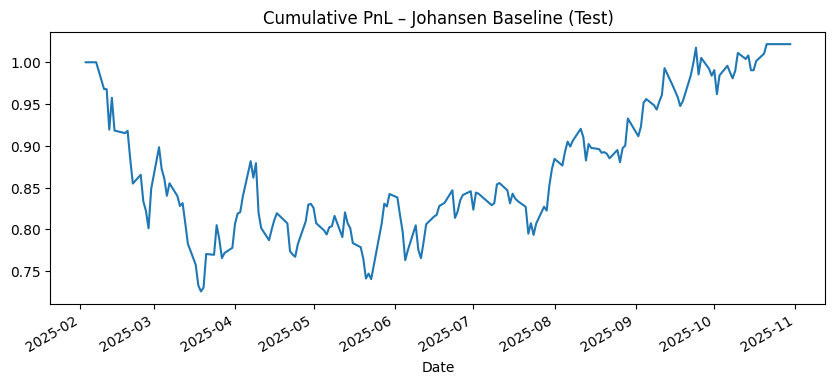

In [21]:
(1 + strat_ret_test).cumprod().plot(figsize=(10,4),
                                    title="Cumulative PnL – Johansen Baseline (Test)")
plt.show()

In [22]:
print("Train set in-sample Sharpe:", shapre_train)
print("Test set out-sample Sharpe:", sharpe_test)

Train set in-sample Sharpe: 1.100295554606335
Test set out-sample Sharpe: 0.2576891224173307


In [23]:
print("Mean daily return:", strat_ret_test.mean())
print("Std daily return :", strat_ret_test.std(ddof=1))
print("Fraction of days in a position:",
      (weight_test.abs().sum(axis=1) > 0).mean())

Mean daily return: 0.0003661403821963089
Std daily return : 0.02255546653600829
Fraction of days in a position: 0.9361702127659575
